In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [58]:
from strategy.indicators import compute_atr, compute_vwap
from strategy.utils import calculate_sharpe_ratio, calculate_max_drawdown, calculate_var, plot_equity_curve

sns.set(style="whitegrid")

In [59]:
df = pd.read_csv("data/NIFTY 50_minute_data.csv", parse_dates=['date'])
df = df.rename(columns={'date': 'datetime'})
df = df.set_index('datetime')
df = df.sort_index()
df.head(10)

,open,high,low,close,volume
datetime,,,,,
2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0
2015-01-09 09:20:00,8300.50,8303.00,8298.60,8300.00,0
2015-01-09 09:21:00,8300.65,8302.90,8300.00,8301.85,0
2015-01-09 09:22:00,8302.45,8302.45,8295.00,8295.00,0
2015-01-09 09:23:00,8294.85,8295.35,8293.25,8294.70,0


## Strategy

In [60]:
def run_strategy(df, atr_multiplier=3, risk_pct=0.01, capital=100000):
    mlflow.start_run()

    mlflow.log_param("ATR_multiplier", atr_multiplier)
    mlflow.log_param("risk_per_trade", risk_pct)

    df = compute_atr(df)
    df = compute_vwap(df)

    df['signal'] = 0
    start_time = pd.to_datetime("09:15").time()
    end_time = pd.to_datetime("10:30").time()

    condition = (
        (df['close'] > df['open'] + atr_multiplier * df['ATR']) &
        (df.index.time >= start_time) &
        (df.index.time <= end_time)
    )
    df.loc[condition, 'signal'] = 1
    df['signal'] = df['signal'].shift(1).fillna(0)

    df['returns'] = df['close'].pct_change().shift(-1)
    df['strategy_returns'] = df['signal'] * df['returns']
    df['equity'] = (1 + df['strategy_returns'].fillna(0)).cumprod() * capital

    cum_return = df['equity'].iloc[-1] - capital
    sharpe = calculate_sharpe_ratio(df['strategy_returns'])
    max_dd = calculate_max_drawdown(df['equity'])
    var_95 = calculate_var(df['strategy_returns'])

    mlflow.log_metric("Cumulative_Return", round(cum_return, 2))
    mlflow.log_metric("Sharpe_Ratio", round(sharpe, 4))
    mlflow.log_metric("Max_Drawdown", round(max_dd, 2))
    mlflow.log_metric("VaR_95", round(var_95, 4))

    df['equity'].plot(figsize=(10, 5), title="Equity Curve")
    plt.tight_layout()
    plt.savefig("equity_curve.png")
    mlflow.log_artifact("equity_curve.png")

    mlflow.end_run()
    return df

,open,high,low,close,volume,ATR,vwap,signal,returns,strategy_returns,equity
datetime,,,,,,,,,,,
2025-02-07 15:25:00,23569.45,23570.60,23567.00,23568.10,0,8.650000,NaN,0.0,-0.000030,-0.0,101504.749376
2025-02-07 15:26:00,23568.10,23570.25,23565.30,23567.40,0,8.560714,NaN,0.0,0.000386,0.0,101504.749376
2025-02-07 15:27:00,23569.00,23578.35,23565.40,23576.50,0,9.182143,NaN,0.0,-0.000356,-0.0,101504.749376
2025-02-07 15:28:00,23577.05,23578.60,23567.45,23568.10,0,9.682143,NaN,0.0,-0.000210,-0.0,101504.749376
2025-02-07 15:29:00,23568.10,23571.35,23557.35,23563.15,0,9.632143,NaN,0.0,NaN,NaN,101504.749376


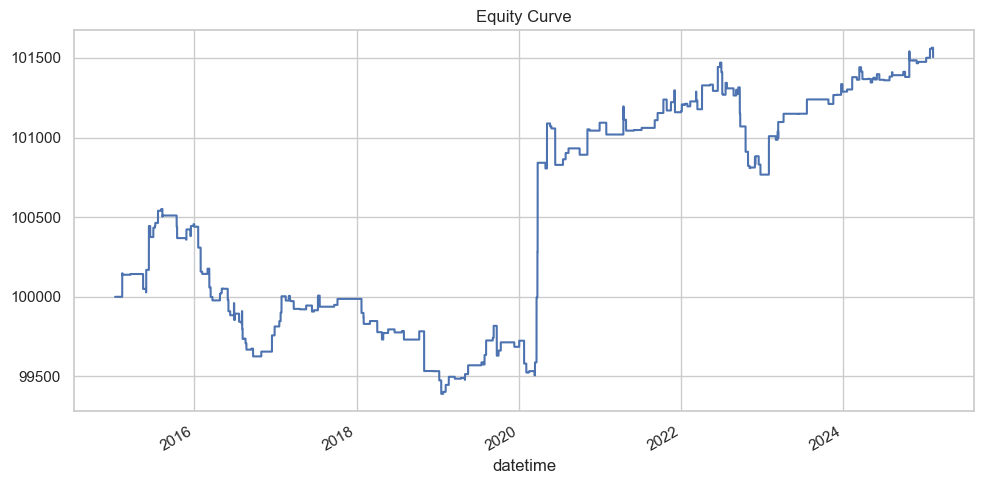

In [62]:
strategy_df = run_strategy(df.copy(), atr_multiplier=3, risk_pct=0.01)
strategy_df.tail()


<Axes: title={'center': 'Rolling Sharpe Ratio (100 1-min intervals)'}, xlabel='datetime'>

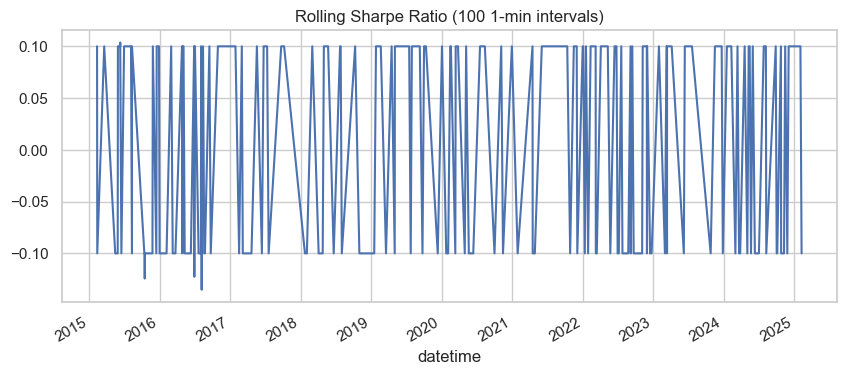

In [64]:
# 📈 Step 6: Rolling Sharpe Plot
rolling_sharpe = (
    strategy_df['strategy_returns']
    .rolling(100)
    .mean() / strategy_df['strategy_returns'].rolling(100).std()
).dropna()

rolling_sharpe.plot(figsize=(10, 4), title="Rolling Sharpe Ratio (100 1-min intervals)")


In [65]:
summary = {
    "Total Trades": strategy_df['signal'].sum(),
    "Cumulative Return": strategy_df['equity'].iloc[-1] - 100000,
    "Sharpe Ratio": strategy_df['strategy_returns'].mean() / strategy_df['strategy_returns'].std() * np.sqrt(252 * 375),
    "Max Drawdown": (strategy_df['equity'].cummax() - strategy_df['equity']).max(),
    "VaR 95%": np.percentile(strategy_df['strategy_returns'].dropna(), 5)
}

pd.Series(summary).apply(lambda x: round(x, 2))

Total Trades          225.00
Cumulative Return    1504.75
Sharpe Ratio            0.37
Max Drawdown         1160.55
VaR 95%                 0.00
dtype: float64

Text(0.5, 1.0, 'Monte Carlo Final Equity Distribution (100 min)')

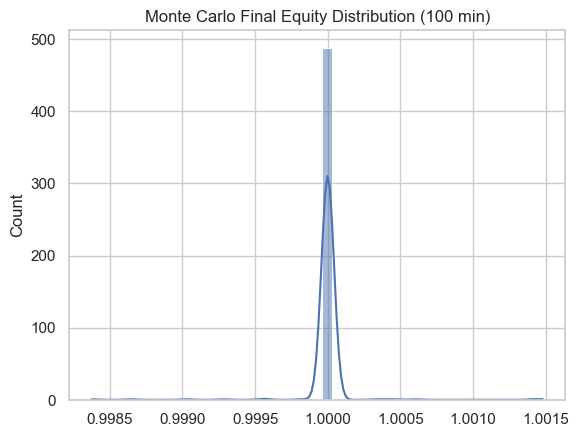

In [66]:
def monte_carlo_simulation(returns, n_sim=500, n_periods=100):
    results = []
    for _ in range(n_sim):
        sim_returns = np.random.choice(returns.dropna(), size=n_periods)
        results.append(np.prod(1 + sim_returns))
    return results

sim_results = monte_carlo_simulation(strategy_df['strategy_returns'])
sns.histplot(sim_results, kde=True)
plt.title("Monte Carlo Final Equity Distribution (100 min)")